In [4]:
import numpy as np
import sklearn.utils
import sklearn.preprocessing
import sklearn.metrics
import sklearn.cluster
import sklearn.datasets
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd

import keras
from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers
from keras.callbacks import TensorBoard
import time

In [5]:
# Fixup for keras for Tensorboard > 0.12
import tensorflow as tf
tf.merge_all_summaries = tf.summary.merge_all
tf.train.SummaryWriter = tf.summary.FileWriter

In [6]:
import pickle, gzip
f = gzip.open('./datasets/mnist.pkl.gz', 'rb')
(train_set,train_set_target), (validation_set,validation_set_target) = [(data, target) for (data,target) in pickle.load(f, encoding='latin1')]
f.close()
# vectorize and normalize
train_set, validation_set = ( np.reshape(data, (data.shape[0],data.shape[1]*data.shape[2])) / 255 for data in (train_set, validation_set))

In [7]:
feature_count, train_set_size, validation_set_size = train_set.shape[1], train_set.shape[0], validation_set.shape[0]
print('Feature Count:', feature_count, 'Training Set Size:', train_set_size, 'Validation Set Size:', validation_set_size)
tolerated_err_per_feature = 0.1
mse_convergence_goal = (tolerated_err_per_feature**2)
mse_upper_bound = (1**2)
ce_convergence_goal = - (0 * np.log(tolerated_err_per_feature) + (1 * np.log(1-tolerated_err_per_feature)))
print('MSE Upper Bound:', mse_upper_bound, ', MSE Convergence Goal:', mse_convergence_goal, 'CE Concergence Goal:', ce_convergence_goal)

Feature Count: 784 Training Set Size: 60000 Validation Set Size: 10000
MSE Upper Bound: 1 , MSE Convergence Goal: 0.010000000000000002 CE Concergence Goal: 0.105360515658


In [8]:
def plot_mnist(data, labels=[]):#, reconstruction=[]):
    if len(labels) is 0:
        labels = np.ones(data.shape[0]) * -1    
    plt.figure(figsize=(20,2))
    for i, (obs,label) in enumerate(zip(data,labels)):#,reconstruction):
        pixels = np.array((obs * 255 - 255) * -1, dtype='uint8')
        pixels = pixels.reshape((28, 28))
        # Plot
        ax = plt.subplot(2, data.shape[0], i + 1)
        if label >= 0:
            plt.title(label)
        plt.grid(False)
        plt.axis('off')
        plt.imshow(pixels, cmap='gray')
    plt.show()

In [1]:
encoded_dim = 32
hidden_layer_count = 1
x = Input(shape=(feature_count,))
h = Dense(
    encoded_dim, 
    activation='relu'
)(x)

y = Dense(feature_count, activation='sigmoid')(h)

ae = Model(input=x, output=y)
encoder = Model(input=x, output=h)
encoded_input = Input(shape=(encoded_dim,))
decoder = Model(input=encoded_input, output=ae.layers[-1](encoded_input))
ae.compile(optimizer='adadelta', loss='binary_crossentropy')

NameError: name 'Input' is not defined

In [10]:
ae.fit(train_set, train_set,
        nb_epoch=50,
        batch_size=256,
        validation_data=(validation_set, validation_set),
        shuffle=True,
        verbose=0,
        callbacks=[TensorBoard(log_dir=('./log/{0}'.format(time.asctime().replace(":","h",1).replace(":","m",1))))]
)

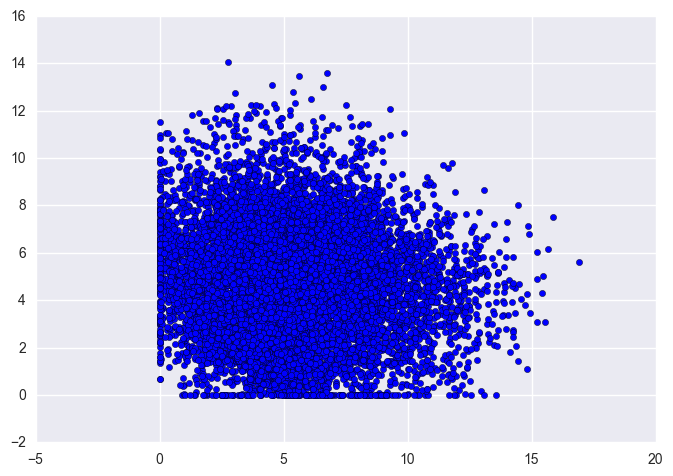

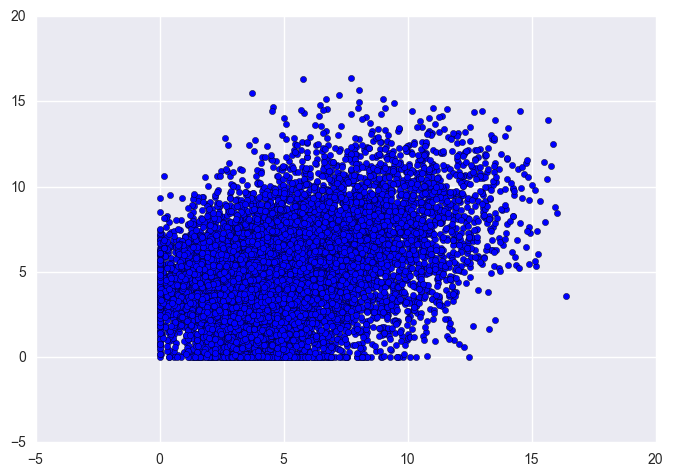

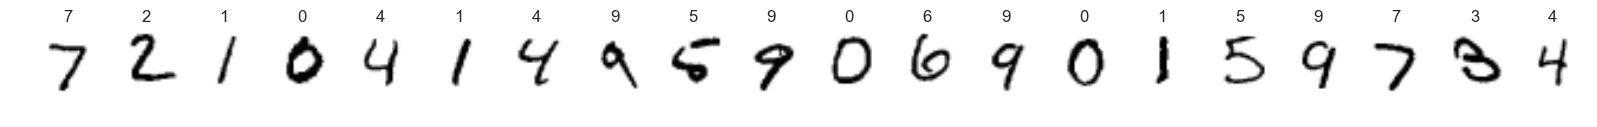

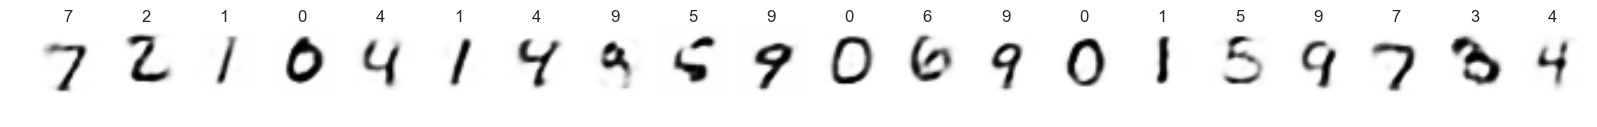

In [11]:
encoded = encoder.predict(validation_set)
reconstructed = decoder.predict(encoded)
plt.scatter(
    x=encoded[:,0],
    y=encoded[:,1]
)
plt.show()
plt.scatter(
    x=encoded[:,2],
    y=encoded[:,3]
)
plt.show()
indices_to_plot = np.arange(0,20)
plot_mnist(validation_set[indices_to_plot], labels=validation_set_target[indices_to_plot])
plot_mnist(reconstructed[indices_to_plot], labels=validation_set_target[indices_to_plot])

In [238]:
import autoencoder
import imp
Autoencoder = imp.reload(autoencoder).Autoencoder
clustering_ae = Autoencoder([feature_count, encoded_dim, feature_count], training_set=train_set, validation_set=validation_set)
clustering_ae.set_parameters(ae.get_weights())
clustering_ae.cluster(k=10, q=0.0005, epochs=40, eta=0.01, mu=0.6, minibatch_size=256, plot_clusters_every_nth_epoch=-1, collect_stats_every_nth_epoch=1, verbose=True)
clustering_ae.plot_stats()
clustering_ae.plot_stats(stacked=True)

Starting training with initial training cost: 0.2427244825904502 and validation cost: 0.24305041965938975
Epoch 1 Total Cost: 0.2408577289573118 Total Cost Validation: 0.2410674075364403
Epoch 2 Total Cost: 0.2388335924228739 Total Cost Validation: 0.23904333863018898
Epoch 3 Total Cost: 0.23697900092155205 Total Cost Validation: 0.23719149950339133
Epoch 4 Total Cost: 0.2352230155326463 Total Cost Validation: 0.23542201994097148
Epoch 5 Total Cost: 0.23353343005659122 Total Cost Validation: 0.2337157861200645
Epoch 6 Total Cost: 0.23189891242094085 Total Cost Validation: 0.2320689418147925
Epoch 7 Total Cost: 0.230312521237908 Total Cost Validation: 0.23046822531169717
Epoch 8 Total Cost: 0.22877162257456446 Total Cost Validation: 0.22891069457442317
Epoch 9 Total Cost: 0.2272708249161653 Total Cost Validation: 0.22738972732406193
Epoch 10 Total Cost: 0.225804449242474 Total Cost Validation: 0.22590909220844757
Epoch 11 Total Cost: 0.22437040115845266 Total Cost Validation: 0.22447043

TypeError: extend() takes exactly one argument (2 given)

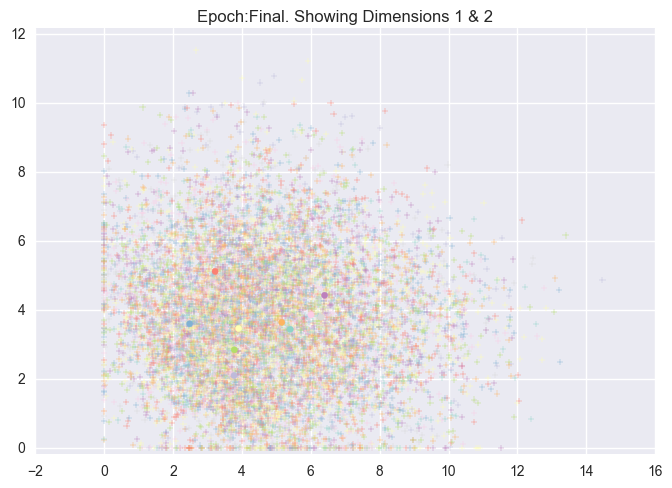

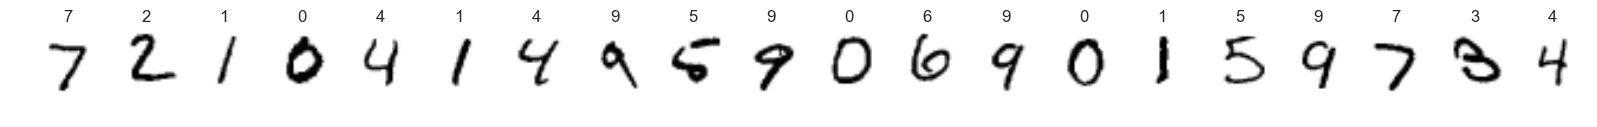

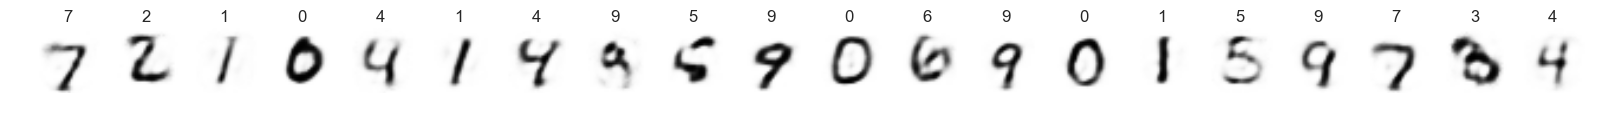

In [239]:
c_encoded = clustering_ae.encode(validation_set)
c_reconstructed = clustering_ae.decode(c_encoded)
clustering_ae.plot_clusters(validation_set, fixed_view=False, epoch='Final. Showing Dimensions 1 & 2')
indices_to_plot = np.arange(0,20)
plot_mnist(validation_set[indices_to_plot], labels=validation_set_target[indices_to_plot])
plot_mnist(c_reconstructed[indices_to_plot], labels=validation_set_target[indices_to_plot])

In [240]:
del(methods[-1])
methods.append({
    'name': 'Clustering Autoencoder',
    'clustering': clustering_ae.get_cluster_assignment(validation_set)
})
results = {}
def evaluate_clustering_method(m):
    precision = 3
    return {
        'Adjusted Rand Score': round(sklearn.metrics.adjusted_rand_score(validation_set_target, m['clustering']),precision),
        'Normalized Mutual Information': round(sklearn.metrics.normalized_mutual_info_score(validation_set_target, m['clustering']),precision),
        'Adjusted Mutual Information': round(sklearn.metrics.adjusted_mutual_info_score(validation_set_target, m['clustering']),precision)
    }
for m in methods:
    results[m['name']] = evaluate_clustering_method(m)


In [ ]:
methods = [{
    'name': 'K-Means',
    'clustering': sklearn.cluster.KMeans(n_clusters=10, max_iter=1000, n_init=50).fit(validation_set).labels_
},{
    'name': 'Spectral Clustering',
    'clustering': sklearn.cluster.SpectralClustering(n_clusters=10, eigen_solver='arpack', affinity="nearest_neighbors").fit(validation_set).labels_
},{
    'name': 'DBScan',
    'clustering': sklearn.cluster.DBSCAN().fit(validation_set).labels_
},{
    'name': 'K-Means on H',
    'clustering': sklearn.cluster.KMeans(n_clusters=10, max_iter=1000, n_init=50).fit(encoded).labels_
}
,{
    'name': 'Clustering Autoencoder',
    'clustering': ae.get_cluster_assignment(validation_set)
}
]

results = {}
for m in methods:
    res = results[m['name']] = {}
    prec = 3
    res['Adjusted Rand Score'] = round(sklearn.metrics.adjusted_rand_score(validation_set_target, m['clustering']),prec)
    res['Normalized Mutual Information'] = round(sklearn.metrics.normalized_mutual_info_score(validation_set_target, m['clustering']),prec)
    res['Adjusted Mutual Information'] = round(sklearn.metrics.adjusted_mutual_info_score(validation_set_target, m['clustering']),prec)

In [241]:
pd.DataFrame(results).transpose()

,Adjusted Mutual Information,Adjusted Rand Score,Normalized Mutual Information
Clustering Autoencoder,0.370,0.246,0.373
DBScan (k not selectable),0.000,0.000,0.000
K-Means,0.496,0.376,0.499
K-Means on H,0.410,0.307,0.416
Spectral Clustering,0.686,0.520,0.702


# Going Deep

In [20]:

import imp
imp.reload(autoencoder_keras)
import mnist_utils


(train,train_target),(validate, validate_target) = mnist_utils.load_data()

import autoencoder_keras
ae = autoencoder_keras.Autoencoder(layers=[784,128,64,32,64,128,784], training_set=train, validation_set=validate)
ae.fit(train, train,
        nb_epoch=100,
        batch_size=256,
        validation_data=(validate, validate),
        shuffle=True,
        verbose=0,
        callbacks=[TensorBoard(log_dir=('./log/{0}'.format(time.asctime().replace(":","h",1).replace(":","m",1))))]
)

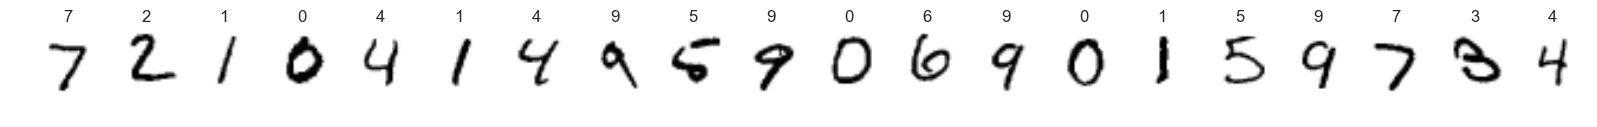

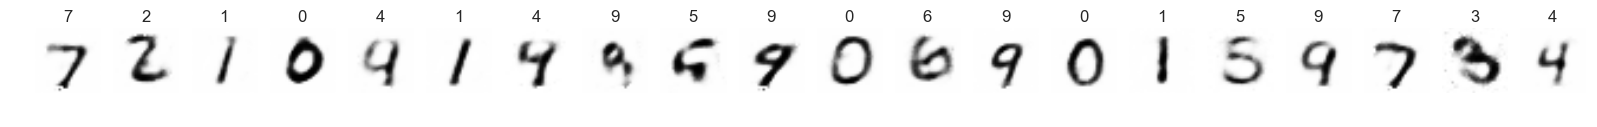

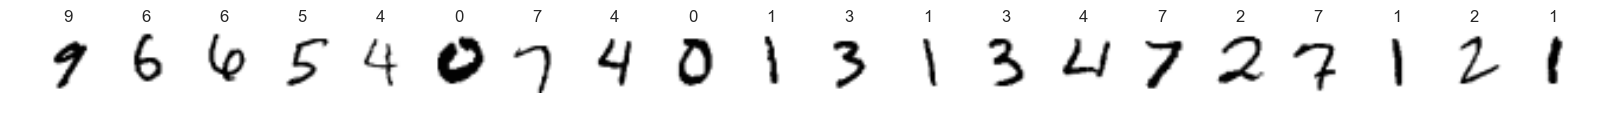

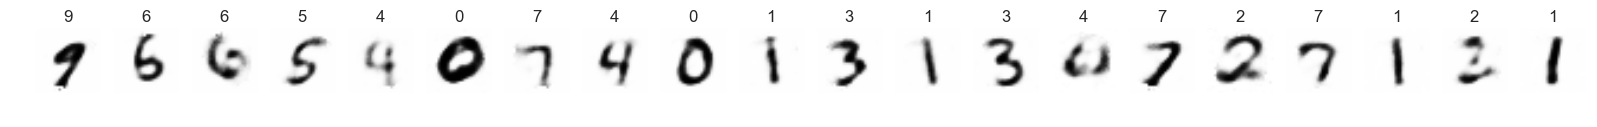

In [27]:
mnist_utils.plot_mnist(validate[0:20], validate_target[0:20])
mnist_utils.plot_mnist(ae.model.predict(validate[0:20]), validate_target[0:20])
mnist_utils.plot_mnist(validate[20:40], validate_target[20:40])
mnist_utils.plot_mnist(ae.model.predict(validate[20:40]), validate_target[20:40])
encoded = ae.encode(validate)

In [28]:
methods = [{
    'name': 'K-Means',
    'clustering': sklearn.cluster.KMeans(n_clusters=10, max_iter=1000, n_init=50).fit(validation_set).labels_
},{
    'name': 'Spectral Clustering',
    'clustering': sklearn.cluster.SpectralClustering(n_clusters=10, eigen_solver='arpack', affinity="nearest_neighbors").fit(validation_set).labels_
},{
    'name': 'DBScan',
    'clustering': sklearn.cluster.DBSCAN().fit(validation_set).labels_
},{
    'name': 'K-Means on H',
    'clustering': sklearn.cluster.KMeans(n_clusters=10, max_iter=1000, n_init=50).fit(encoded).labels_
}
# ,{
#     'name': 'Clustering Autoencoder',
#     'clustering': ae.get_cluster_assignment(validation_set)
# }
]

results = {}
for m in methods:
    res = results[m['name']] = {}
    prec = 3
    res['Adjusted Rand Score'] = round(sklearn.metrics.adjusted_rand_score(validation_set_target, m['clustering']),prec)
    res['Normalized Mutual Information'] = round(sklearn.metrics.normalized_mutual_info_score(validation_set_target, m['clustering']),prec)
    res['Adjusted Mutual Information'] = round(sklearn.metrics.adjusted_mutual_info_score(validation_set_target, m['clustering']),prec)

In [29]:
pd.DataFrame(results).transpose()

,Adjusted Mutual Information,Adjusted Rand Score,Normalized Mutual Information
DBScan,0.000,0.000,0.000
K-Means,0.502,0.384,0.504
K-Means on H,0.403,0.279,0.406
Spectral Clustering,0.688,0.523,0.704
